In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPool2D, Dense, GlobalAveragePooling2D
from keras.models import load_model

In [13]:
def fire_module(x, squeeze_filters, expand_filters):
    squeeze = tf.keras.layers.Conv2D(filters=squeeze_filters, kernel_size=1, activation='relu', padding='same')(x)
    expand_1x1 = tf.keras.layers.Conv2D(filters=expand_filters, kernel_size=1, activation='relu', padding='same')(squeeze)
    expand_3x3 = tf.keras.layers.Conv2D(filters=expand_filters, kernel_size=3, activation='relu', padding='same')(squeeze)
    expand = tf.keras.layers.Concatenate()([expand_1x1, expand_3x3])
    return expand

def SqueezeNet(input_shape=(64, 64, 3), num_classes=7):
    input = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, activation='relu', padding='same')(input)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2)(x)
    x = fire_module(x, squeeze_filters=16, expand_filters=64)
    x = fire_module(x, squeeze_filters=16, expand_filters=64)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2)(x)
    x = fire_module(x, squeeze_filters=32, expand_filters=128)
    x = fire_module(x, squeeze_filters=32, expand_filters=128)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2)(x)
    x = fire_module(x, squeeze_filters=48, expand_filters=192)
    x = fire_module(x, squeeze_filters=48, expand_filters=192)
    x = fire_module(x, squeeze_filters=64, expand_filters=256)
    x = fire_module(x, squeeze_filters=64, expand_filters=256)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Conv2D(filters=num_classes, kernel_size=1, activation='relu', padding='valid')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    output = tf.keras.layers.Activation('softmax')(x)
    model = tf.keras.Model(inputs=input, outputs=output)
    return model

# Define function to load and preprocess images
def load_and_preprocess_image(image_path):
    # Load image
    img = load_img(image_path, target_size=(64, 64))
    # Convert image to array
    img_arr = img_to_array(img)
    # Normalize pixel values
    img_arr = img_arr / 255.0
    # Return preprocessed image
    return img_arr



In [3]:
# Define paths to image directory and label csv file
image_dir = 'Cell_Data/Cell_Images/cells'
label_file = 'Cell_Data/label.csv'

# Load label csv file
labels_df = pd.read_csv(label_file)

# Create lists to store image paths and labels
image_paths = []
labels = []

# Loop over each row in the label csv file and extract image path and label
for index, row in labels_df.iterrows():
    image_name = row['image_name']
    label = row['label']
    image_path = os.path.join(image_dir, image_name)
    image_paths.append(image_path)
    labels.append(label)

# Convert labels to numpy array
labels = np.array(labels)

# Split data into training and testing sets
train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

In [4]:
# Load and preprocess training images
train_images = []
for image_path in train_image_paths:
    img = load_and_preprocess_image(image_path)
    train_images.append(img)
train_images = np.array(train_images)

# Load and preprocess testing images
test_images = []
for image_path in test_image_paths:
    img = load_and_preprocess_image(image_path)
    test_images.append(img)
test_images = np.array(test_images)

In [14]:
# Create the model
model = SqueezeNet()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_78 (Conv2D)             (None, 32, 32, 64)   1792        ['input_4[0][0]']                
                                                                                                  
 max_pooling2d_9 (MaxPooling2D)  (None, 15, 15, 64)  0           ['conv2d_78[0][0]']              
                                                                                                  
 conv2d_79 (Conv2D)             (None, 15, 15, 16)   1040        ['max_pooling2d_9[0][0]']        
                                                                                            

In [15]:
# Define some callbacks
early_stop = EarlyStopping(patience=3, monitor='val_loss')
checkpointer = ModelCheckpoint(filepath='best_model.h5', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(train_images, train_labels, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stop, checkpointer])

Epoch 1/20
1269/1269 [==============================] - 123s 94ms/step - loss: 1.0646 - accuracy: 0.5557 - val_loss: 0.6573 - val_accuracy: 0.7625
Epoch 2/20
1269/1269 [==============================] - 113s 89ms/step - loss: 0.5892 - accuracy: 0.7805 - val_loss: 0.6248 - val_accuracy: 0.7648
Epoch 3/20
1269/1269 [==============================] - 108s 85ms/step - loss: 0.5042 - accuracy: 0.8162 - val_loss: 0.5404 - val_accuracy: 0.8077
Epoch 4/20
1269/1269 [==============================] - 108s 85ms/step - loss: 0.4509 - accuracy: 0.8342 - val_loss: 0.4527 - val_accuracy: 0.8342
Epoch 5/20
1269/1269 [==============================] - 115s 90ms/step - loss: 0.4126 - accuracy: 0.8500 - val_loss: 0.4923 - val_accuracy: 0.8150
Epoch 6/20
1269/1269 [==============================] - 112s 88ms/step - loss: 0.3785 - accuracy: 0.8633 - val_loss: 0.4467 - val_accuracy: 0.8388
Epoch 7/20
1269/1269 [==============================] - 123s 97ms/step - loss: 0.3610 - accuracy: 0.8687 - val_loss: 0

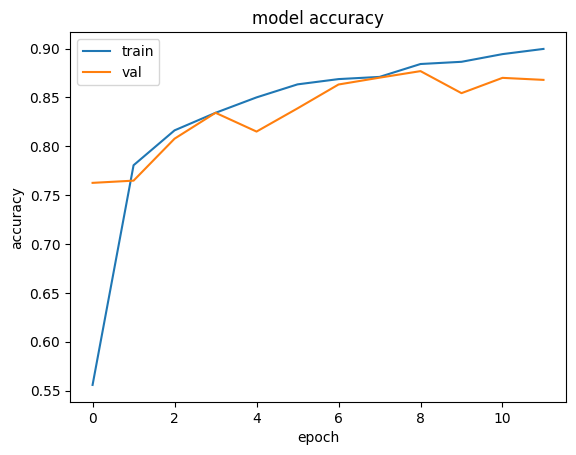

In [16]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

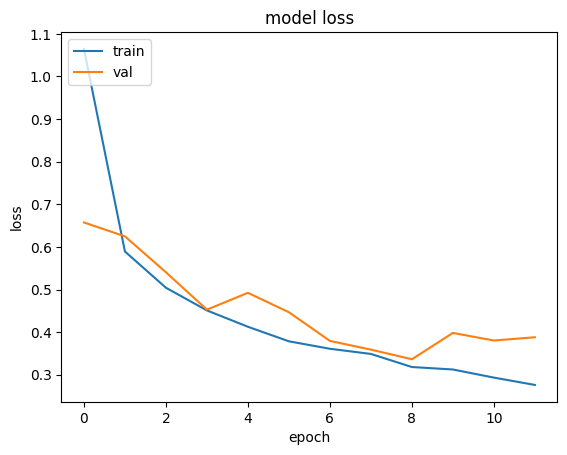

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
best_model = load_model('best_model.h5')

# Evaluate the model on the testing set
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

397/397 [==============================] - 11s 26ms/step - loss: 0.3246 - accuracy: 0.8800
Test loss: 0.3245784640312195
Test accuracy: 0.8799747824668884


In [20]:
result = model.predict(test_images,)

397/397 [==============================] - 9s 23ms/step


In [30]:
result[0]
y_test = np.argmax(result, axis=1)
print(len(y_test))
print(len(test_labels))

12689
12689


In [32]:
from sklearn.metrics import confusion_matrix

# Assume y_true and y_pred are the true and predicted labels, respectively
y_true = test_labels
y_pred = y_test

# Get the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)


[[2570  227   31    0   32    0]
 [ 301 2432   56   20   64    1]
 [  48   36 2550   10   41    1]
 [   6  407  164 2163    2    3]
 [  97   26   20    0  862    2]
 [   7   14   41    2   50  403]]


In [34]:
# Loop over the rows and columns of the confusion matrix to extract TP, TN, FP, and FN numbers for each class
for i in range(len(cm)):
    tp = cm[i,i]
    fp = sum(cm[:,i]) - tp
    fn = sum(cm[i,:]) - tp
    tn = sum(sum(cm)) - tp - fp - fn
    
    print(f"Class {i+1}")
    print("True Positives (TP): ", tp)
    print("True Negatives (TN): ", tn)
    print("False Positives (FP): ", fp)
    print("False Negatives (FN): ", fn)

Class 1
True Positives (TP):  2570
True Negatives (TN):  9370
False Positives (FP):  459
False Negatives (FN):  290
Class 2
True Positives (TP):  2432
True Negatives (TN):  9105
False Positives (FP):  710
False Negatives (FN):  442
Class 3
True Positives (TP):  2550
True Negatives (TN):  9691
False Positives (FP):  312
False Negatives (FN):  136
Class 4
True Positives (TP):  2163
True Negatives (TN):  9912
False Positives (FP):  32
False Negatives (FN):  582
Class 5
True Positives (TP):  862
True Negatives (TN):  11493
False Positives (FP):  189
False Negatives (FN):  145
Class 6
True Positives (TP):  403
True Negatives (TN):  12165
False Positives (FP):  7
False Negatives (FN):  114
